# Imports

In [3]:
import pandas as pd
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, HeteroConv
from torch_geometric.transforms import RandomLinkSplit
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling
import networkx as nx
from torch.nn import BatchNorm1d
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from transformers import T5Tokenizer, T5Model
import requests

# Step 1 -> Load Dataset

In [5]:
df = pd.read_csv('new_chembl_inhibit_drug_target.csv')  # Replace with your CSV path
df = df[['compound_chembl_id', 'target_accession_number']]
df.drop_duplicates(inplace=True)

# Step 2 -> Construct the graph

In [3]:
# Set up the device (use CUDA if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

# Initialize HeteroData object
data = HeteroData()

num_features = 64

# Add compound nodes
compounds = df['compound_chembl_id'].unique()
compound_map = {compound: i for i, compound in enumerate(compounds)}

# Add target nodes
targets = df['target_accession_number'].unique()
target_map = {target: i for i, target in enumerate(targets)}

# Add edges (compound -> target)
compound_indices = np.array(df['compound_chembl_id'].map(compound_map).values)
target_indices = np.array(df['target_accession_number'].map(target_map).values)

# Move edge indices to GPU
data['compound', 'interacts', 'target'].edge_index = torch.tensor(np.vstack([compound_indices, target_indices]), dtype=torch.long).to(device)
data['target', 'interacts', 'compound'].edge_index = torch.tensor(np.vstack([target_indices, compound_indices]), dtype=torch.long).to(device)

cancer_ppi_data = pd.read_csv('cancer_ppi_combined.csv')

protein_map = {target: i for i, target in enumerate(df['target_uniprot_id'].unique())}

existing_proteins = set(protein_map.keys())
cancer_ppi_data_filtered = cancer_ppi_data[(cancer_ppi_data['node1_uniprot_id'].isin(existing_proteins)) | (cancer_ppi_data['node2_uniprot_id'].isin(existing_proteins))]

# Convert to a NetworkX graph
# G = nx.Graph()
# G.add_nodes_from(compounds)
# G.add_nodes_from(targets)
# edges = data['compound', 'interacts', 'target'].edge_index.cpu().numpy()
# compound_indices, target_indices = edges
# for compound_idx, target_idx in zip(compound_indices, target_indices):
#     compound = compounds[compound_idx]
#     target = targets[target_idx]
#     G.add_edge(compound, target)

# # Calculate HITS scores
# hubs, authorities = nx.hits(G, max_iter=100, tol=1e-08, normalized=True)

# # Create tensors for hub and authority scores
# compound_hub_scores = torch.tensor([hubs[compound] for compound in compounds], dtype=torch.float).to(device)
# compound_authority_scores = torch.tensor([authorities[compound] for compound in compounds], dtype=torch.float).to(device)

# target_hub_scores = torch.tensor([hubs[target] for target in targets], dtype=torch.float).to(device)
# target_authority_scores = torch.tensor([authorities[target] for target in targets], dtype=torch.float).to(device)

# data['compound'].x = torch.cat([compound_hub_scores.unsqueeze(1), compound_authority_scores.unsqueeze(1)], dim=1)
# data['target'].x = torch.cat([target_hub_scores.unsqueeze(1), target_authority_scores.unsqueeze(1)], dim=1)

# reverse_edges = data['target', 'interacts_with', 'compound'].edge_index.cpu().numpy()
# target_indices_rev, compound_indices_rev = reverse_edges
# for target_idx, compound_idx in zip(target_indices_rev, compound_indices_rev):
#     target = targets[target_idx]
#     compound = compounds[compound_idx]
#     G.add_edge(target, compound)  # Directed edge from target -> compound

# # Compute betweenness centrality
# betweenness_centrality = nx.betweenness_centrality(G, k=100, normalized=True, seed=42, endpoints=False)

# # Compute eigenvector centrality
# eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=200)

# # You can also compute degree for neighborhood features
# degree = dict(G.degree())

# # Extract centrality scores for compounds and targets separately
# compound_betweenness = [betweenness_centrality[compound] for compound in compounds]
# target_betweenness = [betweenness_centrality[target] for target in targets]

# compound_eigenvector = [eigenvector_centrality[compound] for compound in compounds]
# target_eigenvector = [eigenvector_centrality[target] for target in targets]

# compound_degree = [degree[compound] for compound in compounds]
# target_degree = [degree[target] for target in targets]

# # Convert the centrality and degree features to tensors
# compound_betweenness_tensor = torch.tensor(compound_betweenness, dtype=torch.float).to(device)
# target_betweenness_tensor = torch.tensor(target_betweenness, dtype=torch.float).to(device)

# compound_eigenvector_tensor = torch.tensor(compound_eigenvector, dtype=torch.float).to(device)
# target_eigenvector_tensor = torch.tensor(target_eigenvector, dtype=torch.float).to(device)

# compound_degree_tensor = torch.tensor(compound_degree, dtype=torch.float).to(device)
# target_degree_tensor = torch.tensor(target_degree, dtype=torch.float).to(device)

# # Concatenate these features with the existing node features
# # Assuming data['compound'].x and data['target'].x already contain features
# data['compound'].x = torch.cat([data['compound'].x, compound_betweenness_tensor.unsqueeze(1), 
#                                 compound_eigenvector_tensor.unsqueeze(1), compound_degree_tensor.unsqueeze(1)], dim=1)
# data['target'].x = torch.cat([data['target'].x, target_betweenness_tensor.unsqueeze(1), 
#                               target_eigenvector_tensor.unsqueeze(1), target_degree_tensor.unsqueeze(1)], dim=1)

In [4]:
# Map PPI to indices
ppi_edges = cancer_ppi_data_filtered.apply(
    lambda row: (protein_map.get(row['node1_uniprot_id'], -1), 
                 protein_map.get(row['node2_uniprot_id'], -1)), axis=1)

ppi_edges = [edge for edge in ppi_edges if -1 not in edge]

# Add PPI edges to the graph
if ppi_edges:
    data['target', 'interacts', 'target'].edge_index = torch.tensor(ppi_edges, dtype=torch.long).T

In [16]:
print(cancer_ppi_data_filtered)

      node1_uniprot_id node2_uniprot_id
113             Q6GPI1           P09683
114             Q6GPI1           P01298
201             P60709           Q99835
221             P60709           Q9NYK1
222             P60709           Q9NZQ7
...                ...              ...
39749           Q99759           P00533
39761           P46109           P00533
39788           Q9Y2R2           P00533
39799           Q15047           Q9Y6K1
39801           Q9Y6K1           Q15047

[3570 rows x 2 columns]


In [23]:
print(len(df['compound_chembl_id']))

70902


In [61]:
def fetch_smiles_set(chembl_ids):
    url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/set/{';'.join(chembl_ids)}"
    
    # Add the 'Accept' header to explicitly request JSON format
    headers = {
        'Accept': 'application/json',
    }

    try:
        # Set a timeout of 10 seconds (you can adjust this as needed)
        response = requests.get(url, headers=headers, timeout=10)
        
        if response.status_code == 200:
            try:
                data = response.json()  # Parse JSON response
                smiles_dict = {}
                for molecule in data.get('molecules', []):
                    smiles = molecule.get('molecule_structures', {}).get('canonical_smiles', None)
                    chembl_id = molecule['molecule_chembl_id']
                    smiles_dict[chembl_id] = smiles
                return smiles_dict
            except:
                print("Error")
                return {}
        else:
            print(f"Error: Received status code {response.status_code}")
            return {}
    except requests.exceptions.ConnectTimeout:
        print("Connection timed out. Please check your network or try again later.")
        return {}
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return {}

def fetch_all_smiles(df, batch_size=100):
    unique_chembl_ids = df['compound_chembl_id'].unique()
    smiles_dict = {}

    # Fetch SMILES in batches using the /set/ endpoint
    for i in range(0, len(unique_chembl_ids), batch_size):
        batch_ids = unique_chembl_ids[i:i+batch_size]
        batch_smiles = fetch_smiles_set(batch_ids)
        smiles_dict.update(batch_smiles)
        print(f"Batch number: {i/batch_size}")

    return smiles_dict

# Example usage
smiles_dict = fetch_all_smiles(df, batch_size=250)

df['compound_smiles'] = df['compound_chembl_id'].map(smiles_dict)

Error
Batch number: 0.0
Batch number: 1.0
Batch number: 2.0
Batch number: 3.0
Batch number: 4.0
Batch number: 5.0
Batch number: 6.0
Batch number: 7.0
Batch number: 8.0
Error
Batch number: 9.0
Batch number: 10.0
Batch number: 11.0
Error
Batch number: 12.0
Batch number: 13.0
Batch number: 14.0
Batch number: 15.0
Batch number: 16.0
Batch number: 17.0
Batch number: 18.0
Batch number: 19.0
Batch number: 20.0
Batch number: 21.0
Batch number: 22.0
Batch number: 23.0
Batch number: 24.0
Error
Batch number: 25.0
Batch number: 26.0
Batch number: 27.0
Error
Batch number: 28.0
Batch number: 29.0
Batch number: 30.0
Error
Batch number: 31.0
Batch number: 32.0
Batch number: 33.0
Error
Batch number: 34.0
Batch number: 35.0
Batch number: 36.0
Error
Batch number: 37.0
Batch number: 38.0
Batch number: 39.0
Batch number: 40.0
Batch number: 41.0
Batch number: 42.0
Batch number: 43.0
Error
Batch number: 44.0
Batch number: 45.0
Batch number: 46.0
Batch number: 47.0
Batch number: 48.0
Error
Batch number: 49.0


In [62]:
df.to_csv('new_chembl_inhibit_drug_target_1.csv', index=False)

In [93]:
nan_smiles_df = df[df['compound_smiles'].isna()]
print(len(nan_smiles_df))

missing_smiles_dict = fetch_all_smiles(nan_smiles_df, batch_size=1)

75
Batch number: 0.0
Error
Batch number: 1.0
Error
Batch number: 2.0
Batch number: 3.0
Batch number: 4.0
Error
Batch number: 5.0
Error
Batch number: 6.0
Batch number: 7.0
Batch number: 8.0
Error
Batch number: 9.0
Error
Batch number: 10.0
Batch number: 11.0
Batch number: 12.0
Error
Batch number: 13.0
Batch number: 14.0
Error
Batch number: 15.0
Error
Batch number: 16.0
Batch number: 17.0
Error
Batch number: 18.0
Batch number: 19.0
Error
Batch number: 20.0
Batch number: 21.0
Error
Batch number: 22.0
Batch number: 23.0
Batch number: 24.0
Error
Batch number: 25.0
Batch number: 26.0
Error
Batch number: 27.0
Batch number: 28.0
Error
Batch number: 29.0
Error
Batch number: 30.0
Batch number: 31.0
Error
Batch number: 32.0
Batch number: 33.0
Error
Batch number: 34.0
Batch number: 35.0
Batch number: 36.0
Error
Batch number: 37.0
Error
Batch number: 38.0
Batch number: 39.0
Batch number: 40.0
Error
Batch number: 41.0
Error
Batch number: 42.0
Batch number: 43.0
Error
Batch number: 44.0
Error
Batch nu

In [94]:
def fill_missing_smiles(row):
    if pd.isna(row['compound_smiles']):  # Check if the current value is NaN
        chembl_id = row['compound_chembl_id']  # Get the ChEMBL ID from the row
        return missing_smiles_dict.get(chembl_id, row['compound_smiles'])  # Get the SMILES from the dict or keep NaN if not found
    else:
        return row['compound_smiles']  # Return the existing SMILES if it's not NaN

# Apply the function to fill missing SMILES
df['compound_smiles'] = df.apply(fill_missing_smiles, axis=1)

In [95]:
nan_smiles_df = df[df['compound_smiles'].isna()]
print(len(nan_smiles_df))

37


In [96]:
df.to_csv('new_chembl_inhibit_drug_target_1.csv', index=False)

In [5]:
import math

# Function to extract molecular features using RDKit
def extract_compound_features(smiles_list):
    features = []
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=514)
    for smiles in smiles_list:
        if isinstance(smiles, float) and math.isnan(smiles):
            features.append([0] * (2 + 512))
            continue
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Example: Using molecular weight and LogP as features
            fingerprint = generator.GetFingerprint(mol)
            fingerprint_list = list(fingerprint)  # Convert to list if needed
            features.append(fingerprint_list)
        else:
            features.append([0] * (2 + 512))  # Handle missing molecule cases
    return torch.tensor(features, dtype=torch.float)

compound_features = extract_compound_features(df['compound_smiles'])
data['compound'].x = compound_features.to(device)

In [6]:
print(data['compound'].x)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')


In [8]:
def fetch_uniprot_set(chembl_ids):
    url = f"https://www.ebi.ac.uk/chembl/api/data/target/set/{';'.join(chembl_ids)}"
    
    # Add the 'Accept' header to explicitly request JSON format
    headers = {
        'Accept': 'application/json',
    }

    try:
        # Set a timeout of 10 seconds (you can adjust this as needed)
        response = requests.get(url, headers=headers, timeout=10)
        
        if response.status_code == 200:
            try:
                data = response.json()  # Parse JSON response
                uniprot_dict = {}
                for target in data.get('targets', []):
                    target_components = target.get('target_components', [])
                    for component in target_components:
                        for xref in component.get('target_component_xrefs', []):
                            if xref.get('xref_src_db') == 'UniProt':
                                chembl_id = target['target_chembl_id']
                                uniprot_id = xref.get('xref_id')
                                uniprot_dict[chembl_id] = uniprot_id
                return uniprot_dict
            except Exception as e:
                print(f"Error processing response: {e}")
                return {}
        else:
            print(f"Error: Received status code {response.status_code}")
            return {}
    except requests.exceptions.ConnectTimeout:
        print("Connection timed out. Please check your network or try again later.")
        return {}
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return {}

# Function to fetch all UniProt IDs in batches, similar to fetch_all_smiles
def fetch_all_uniprots(df, batch_size=100):
    unique_chembl_ids = df['target_chembl_id'].unique()  # Assuming 'target_chembl_id' column exists
    uniprot_dict = {}

    # Fetch UniProt IDs in batches using the /target/set/ endpoint
    for i in range(0, len(unique_chembl_ids), batch_size):
        batch_ids = unique_chembl_ids[i:i+batch_size]
        batch_uniprots = fetch_uniprot_set(batch_ids)
        uniprot_dict.update(batch_uniprots)
        print(f"Processed batch number: {i // batch_size + 1}")

    return uniprot_dict

# Example usage
uniprot_dict = fetch_all_uniprots(df, batch_size=250)

# Map the fetched UniProt IDs back to the original DataFrame
df['target_uniprot_id'] = df['target_chembl_id'].map(uniprot_dict)

Processed batch number: 1
Processed batch number: 2
Processed batch number: 3
Processed batch number: 4
Processed batch number: 5


In [12]:
df.to_csv('new_chembl_inhibit_drug_target_1.csv', index=False)

In [6]:
# Load the Prot5 model and tokenizer
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50")
print("Tokenizer loaded")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Tokenizer loaded


In [7]:
model = T5Model.from_pretrained("Rostlab/prot_t5_xl_uniref50").half().to(device)
print("Model loaded")

Model loaded


In [14]:
# Function to fetch protein sequence from UniProt
def fetch_uniprot_sequence(uniprot_id):
    url = f"https://www.uniprot.org/uniprot/{uniprot_id}.fasta"
    response = requests.get(url)
    if response.status_code == 200:
        sequence = ''.join(response.text.splitlines()[1:])  # Skip the FASTA header
        return sequence
    else:
        print(f"Error fetching sequence for {uniprot_id}")
        return None

# Function to generate embeddings for a list of protein sequences
def get_protein_embeddings(uniprot_ids):
    embeddings_dict = {}  # Dictionary to cache embeddings
    num = 0

    for uniprot_id in uniprot_ids:
        num += 1
        if num%20 == 0:
            print(f"Processing uniprot id : {uniprot_id} number {num}")

        try:
            sequence = fetch_uniprot_sequence(uniprot_id)  # Fetch the protein sequence
            if sequence:
                # Tokenize the input sequence
                inputs = tokenizer(sequence, return_tensors="pt", padding=True).to(device)

                # Add decoder_input_ids: initialize with the pad token id
                decoder_input_ids = torch.tensor([[tokenizer.pad_token_id]]).to(device)

                # Forward pass with encoder input and decoder input
                with torch.no_grad():
                    outputs = model(input_ids=inputs['input_ids'], decoder_input_ids=decoder_input_ids)

                # Extract embeddings (e.g., from encoder output or mean pooling)
                embedding = outputs.last_hidden_state.mean(dim=1)  # Mean pooling for simplicity
                embeddings_dict[uniprot_id] = embedding.squeeze(0).cpu().numpy()  # Cache the embedding
            else:
                embeddings_dict[uniprot_id] = [0] * 1024  # Default zero embedding for missing sequences
        except:
            print(f"Error processing uniprot id : {uniprot_id} number {num}")

    return embeddings_dict


# Generate the embeddings for the unique UniProt IDs
unique_uniprot_ids = df['target_uniprot_id'].unique()
print(len(unique_uniprot_ids))
embeddings_dict = get_protein_embeddings(unique_uniprot_ids)

919
Processing uniprot id : Q59GZ4 number 20
Processing uniprot id : Q9BZX1 number 40
Processing uniprot id : Q96RG3 number 60
Processing uniprot id : Q8N7V3 number 80
Processing uniprot id : Q9UMG5 number 100
Processing uniprot id : Q9BVY6 number 120
Processing uniprot id : Q9Y618 number 140
Processing uniprot id : Q9NYL2 number 160
Processing uniprot id : Q5T489 number 180
Processing uniprot id : Q9UCC0 number 200
Processing uniprot id : Q9HAR0 number 220
Processing uniprot id : Q9UHD2 number 240
Processing uniprot id : Q9P0B8 number 260
Processing uniprot id : Q9Y265 number 280
Processing uniprot id : Q2M1P8 number 300
Processing uniprot id : Q9UQ96 number 320
Processing uniprot id : Q99957 number 340
Processing uniprot id : Q969U4 number 360
Processing uniprot id : Q5T7T8 number 380
Processing uniprot id : Q96KA8 number 400
Processing uniprot id : Q9HD26 number 420
Processing uniprot id : Q96CY8 number 440
Processing uniprot id : Q9Y616 number 460
Processing uniprot id : Q68DZ3 num

In [18]:
missing_ids = [m_id for m_id in unique_uniprot_ids if m_id not in embeddings_dict]

In [19]:
print(missing_ids)

['Q9UQ95', 'Q9NQ14']


In [21]:
new_dict = get_protein_embeddings(missing_ids)
print(new_dict)

{'Q9UQ95': array([ 0.1744,  0.2167, -0.1216, ...,  0.1583, -0.0855, -0.5703],
      dtype=float16), 'Q9NQ14': array([ 0.1744,  0.2167, -0.1216, ...,  0.1583, -0.0855, -0.5703],
      dtype=float16)}


In [22]:
embeddings_dict_merged = {**embeddings_dict, **new_dict}
print(len(embeddings_dict_merged))

919


In [27]:
import pickle

with open("embeddings_dict.pkl", "wb") as f:
    pickle.dump(embeddings_dict_merged, f)

In [6]:
import pickle

embeddings_dict_merged = pickle.load(open("embeddings_dict.pkl", "rb"))

In [7]:
# Create a list of embeddings that matches the size of the original dataset
target_features = [embeddings_dict_merged[uniprot_id] for uniprot_id in df['target_uniprot_id']]

data['target'].x = torch.tensor(target_features, dtype=torch.float).to(device)

C:\Users\chakr\AppData\Local\Temp\ipykernel_27496\683727053.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  data['target'].x = torch.tensor(target_features, dtype=torch.float).to(device)


In [8]:
# Check the new feature shapes
print("Compound node features shape", data['compound'].x.shape)
print("Target node features shape", data['target'].x.shape)

# Check shapes to verify
print("Edge index shape:", data['compound', 'interacts', 'target'].edge_index.shape)
print("Reverse edge index shape:", data['target', 'interacts', 'compound'].edge_index.shape)
print("PPI edge index shape:", data['target', 'interacts', 'target'].edge_index.shape)

Compound node features shape torch.Size([70902, 514])
Target node features shape torch.Size([70902, 1024])
Edge index shape: torch.Size([2, 70902])
Reverse edge index shape: torch.Size([2, 70902])
PPI edge index shape: torch.Size([2, 84])


In [9]:
# Apply RandomLinkSplit to generate train, validation, and test sets
transform = RandomLinkSplit(
    num_val=0.1,  # 10% validation edges
    num_test=0.2,  # 20% test edges
    is_undirected=False,  # Keep it directed, set to True for undirected
    add_negative_train_samples=True,  # Generate negative samples for training
    edge_types=('compound', 'interacts', 'target'),
    rev_edge_types=('target', 'interacts', 'compound')
)

# Perform train, val, and test split and move the splits to the GPU
train_data, val_data, test_data = transform(data)

# Move split datasets to the same device
train_data = train_data.to(device)
val_data = val_data.to(device)
test_data = test_data.to(device)

# Define GNN Model

In [10]:
# Define a simple MLP for link prediction
class LinkPredictor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(LinkPredictor, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)  # Output is a single scalar score
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))  # Output between 0 and 1 (probability)

class GNNModel(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GNNModel, self).__init__()
        self.conv1 = HeteroConv({
            ('compound', 'interacts', 'target'): SAGEConv((-1, -1), hidden_channels),
            ('target', 'interacts', 'compound'): SAGEConv((-1, -1), hidden_channels),
            ('target', 'interacts', 'target'): SAGEConv((-1, -1), hidden_channels)
        })
        # Batch normalization after first layer
        self.batchnorm1_compound = BatchNorm1d(hidden_channels)
        self.batchnorm1_target = BatchNorm1d(hidden_channels)
        
        self.conv2 = HeteroConv({
            ('compound', 'interacts', 'target'): SAGEConv(hidden_channels, hidden_channels),
            ('target', 'interacts', 'compound'): SAGEConv(hidden_channels, hidden_channels),
            ('target', 'interacts', 'target'): SAGEConv(hidden_channels, hidden_channels)
        })
        # Batch normalization after second layer
        self.batchnorm2_compound = BatchNorm1d(hidden_channels)
        self.batchnorm2_target = BatchNorm1d(hidden_channels)

        # Define the MLP for link prediction
        input_dim = hidden_channels * 2  # Because we will concatenate embeddings of two nodes
        self.link_predictor = LinkPredictor(input_dim, hidden_dim=hidden_channels)

    def forward(self, x_dict, edge_index_dict):
        # Apply the first convolution layer
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict['compound'] = F.relu(self.batchnorm1_compound(x_dict['compound']))
        x_dict['target'] = F.relu(self.batchnorm1_target(x_dict['target']))

        # Apply the second convolution layer
        x_dict = self.conv2(x_dict, edge_index_dict)
        x_dict['compound'] = self.batchnorm2_compound(x_dict['compound'])
        x_dict['target'] = self.batchnorm2_target(x_dict['target'])

        return x_dict

    def predict_link(self, z_dict, edge_label_index):
        # Extract node embeddings
        source_z = z_dict['compound'][edge_label_index[0]]
        target_z = z_dict['target'][edge_label_index[1]]

        # Concatenate the embeddings of source and target nodes
        z_concat = torch.cat([source_z, target_z], dim=-1).to(device)  # Concatenate along the feature dimension
        
        # Pass the concatenated embeddings through the neural network
        return self.link_predictor(z_concat)  # Output a probability or score for the link
    
    def predict_link_rev(self, z_dict, edge_label_index):
        # Extract node embeddings
        source_z = z_dict['target'][edge_label_index[0]]
        target_z = z_dict['compound'][edge_label_index[1]]

        # Concatenate the embeddings of source and target nodes
        z_concat = torch.cat([source_z, target_z], dim=-1).to(device)  # Concatenate along the feature dimension
        
        # Pass the concatenated embeddings through the neural network
        return self.link_predictor(z_concat)  # Output a probability or score for the link


# Train

In [11]:
model = GNNModel(hidden_channels=64)

# Check for available device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

def train(data, device):
    model.train()

    optimizer.zero_grad()

    # Move the data to the GPU (if it's not already on the same device)
    data = data.to(device)

    # Forward pass
    z_dict = model(data.x_dict, data.edge_index_dict)

    # Positive edges (compound -> target)
    pos_edge_index = data['compound', 'interacts', 'target'].edge_index.to(device)
    pos_link_pred = model.predict_link(z_dict, pos_edge_index).squeeze()

    # Generate negative samples
    neg_edge_index = negative_sampling(
        edge_index=data['compound', 'interacts', 'target'].edge_index.to(device),
        num_nodes=(data['compound'].num_nodes, data['target'].num_nodes),  # Number of source nodes
        num_neg_samples=pos_edge_index.size(1)  # Same number as positive samples
    )
    neg_link_pred = model.predict_link(z_dict, neg_edge_index).squeeze()

    # Combine positive and negative samples for the loss
    link_preds = torch.cat([pos_link_pred, neg_link_pred], dim=0)
    link_labels = torch.cat([
        torch.ones(pos_link_pred.size(0)).to(device),  # Positive samples on the same device
        torch.zeros(neg_link_pred.size(0)).to(device)  # Negative samples on the same device
    ], dim=0)

    # Reverse direction: target -> compound
    pos_edge_index_rev = data['target', 'interacts', 'compound'].edge_index.to(device)
    # print(z_dict, pos_edge_index_rev)
    pos_link_pred_rev = model.predict_link_rev(z_dict, pos_edge_index_rev).squeeze()

    # Generate negative samples
    neg_edge_index_rev = negative_sampling(
        edge_index=data['target', 'interacts', 'compound'].edge_index.to(device),
        num_nodes=(data['target'].num_nodes, data['compound'].num_nodes),  # Number of source nodes
        num_neg_samples=pos_edge_index_rev.size(1)  # Same number as positive samples
    )
    neg_link_pred_rev = model.predict_link_rev(z_dict, neg_edge_index_rev).squeeze()

    # Combine positive and negative samples for reverse edges
    link_pred_rev = torch.cat([pos_link_pred_rev, neg_link_pred_rev], dim=0)
    link_labels_rev = torch.cat([
        torch.ones(pos_link_pred_rev.size(0)).to(device),  # Positive samples (reversed) on the same device
        torch.zeros(neg_link_pred_rev.size(0)).to(device)  # Negative samples (reversed) on the same device
    ], dim=0)

    # Combine both directions
    all_link_preds = torch.cat([link_preds, link_pred_rev], dim=0)
    all_link_labels = torch.cat([link_labels, link_labels_rev], dim=0)

    # Compute loss
    loss = criterion(all_link_preds, all_link_labels)
    loss.backward()
    optimizer.step()

    return loss.item()


# Test

In [13]:
def test(data, edge_label_index, edge_label, device):
    model.eval()
    
    # Move data to GPU if available
    edge_label_index = edge_label_index.to(device)
    edge_label = edge_label.to(device)

    with torch.no_grad():
        # Forward pass on GPU
        # Move each tensor in x_dict and edge_index_dict to the device
        z_dict = model(
            {k: v.to(device) for k, v in data.x_dict.items()},  # Move node features to the device
            {k: v.to(device) for k, v in data.edge_index_dict.items()}  # Move edge indices to the device
        )

        # Positive edges for test set
        pos_edge_index = data['compound', 'interacts', 'target'].edge_index.to(device)
        pos_link_logits = model.predict_link(z_dict, pos_edge_index)

        # Negative edges for test set
        neg_edge_index = negative_sampling(
            edge_index=data['compound', 'interacts', 'target'].edge_index.to(device),
            num_nodes=(data['compound'].num_nodes, data['target'].num_nodes),
            num_neg_samples=pos_edge_index.size(1)
        )
        neg_link_logits = model.predict_link(z_dict, neg_edge_index)

        # Reverse direction: target -> compound
        
        # Positive edges for test set
        pos_edge_index_rev = data['target', 'interacts', 'compound'].edge_index.to(device)
        pos_link_logits_rev = model.predict_link_rev(z_dict, pos_edge_index_rev)

        # Negative edges for test set
        neg_edge_index_rev = negative_sampling(
            edge_index=data['target', 'interacts', 'compound'].edge_index.to(device),
            num_nodes=(data['target'].num_nodes, data['compound'].num_nodes),
            num_neg_samples=pos_edge_index.size(1)
        )
        neg_link_logits_rev = model.predict_link_rev(z_dict, neg_edge_index_rev)

        # Combine logits and labels for both directions
        all_link_logits = torch.cat([pos_link_logits, neg_link_logits, pos_link_logits_rev, neg_link_logits_rev], dim=0)
        all_link_labels = torch.cat([
            torch.ones(pos_link_logits.size(0), device=device),
            torch.zeros(neg_link_logits.size(0), device=device),
            torch.ones(pos_link_logits_rev.size(0), device=device),
            torch.zeros(neg_link_logits_rev.size(0), device=device)
        ], dim=0)

        # Compute probabilities and predictions
        link_probs = all_link_logits.cpu().numpy()
        link_labels = all_link_labels.cpu().numpy()
        
        # Compute AUC
        auc = roc_auc_score(link_labels, link_probs)
        
        # Convert probabilities to binary predictions
        link_pred = (link_probs > 0.5).astype(int)
        
        # Compute accuracy
        acc = accuracy_score(link_labels, link_pred)
    
    return auc, acc


# Driver Code

In [14]:
# Training loop
epochs = 100
for epoch in range(1, epochs + 1):
    loss = train(train_data, device)
    if epoch % 10 == 0:
        val_auc, val_acc = test(val_data, val_data['compound', 'interacts', 'target'].edge_label_index,
                                val_data['compound', 'interacts', 'target'].edge_label, device)
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val Acc: {val_acc:.4f}')

# Final test set evaluation
test_auc, test_acc = test(test_data, test_data['compound', 'interacts', 'target'].edge_label_index,
                          test_data['compound', 'interacts', 'target'].edge_label, device)
print(f'Test AUC: {test_auc:.4f}, Test Accuracy: {test_acc:.4f}')

Epoch 10, Loss: 0.0529, Val AUC: 0.9930, Val Acc: 0.8707
Epoch 20, Loss: 0.0221, Val AUC: 0.9971, Val Acc: 0.9949
Epoch 30, Loss: 0.0200, Val AUC: 0.9975, Val Acc: 0.9965
Epoch 40, Loss: 0.0194, Val AUC: 0.9975, Val Acc: 0.9967
Epoch 50, Loss: 0.0194, Val AUC: 0.9973, Val Acc: 0.9963
Epoch 60, Loss: 0.0182, Val AUC: 0.9973, Val Acc: 0.9965
Epoch 70, Loss: 0.0189, Val AUC: 0.9975, Val Acc: 0.9965
Epoch 80, Loss: 0.0188, Val AUC: 0.9977, Val Acc: 0.9968
Epoch 90, Loss: 0.0189, Val AUC: 0.9976, Val Acc: 0.9966
Epoch 100, Loss: 0.0193, Val AUC: 0.9981, Val Acc: 0.9967
Test AUC: 0.9977, Test Accuracy: 0.9959


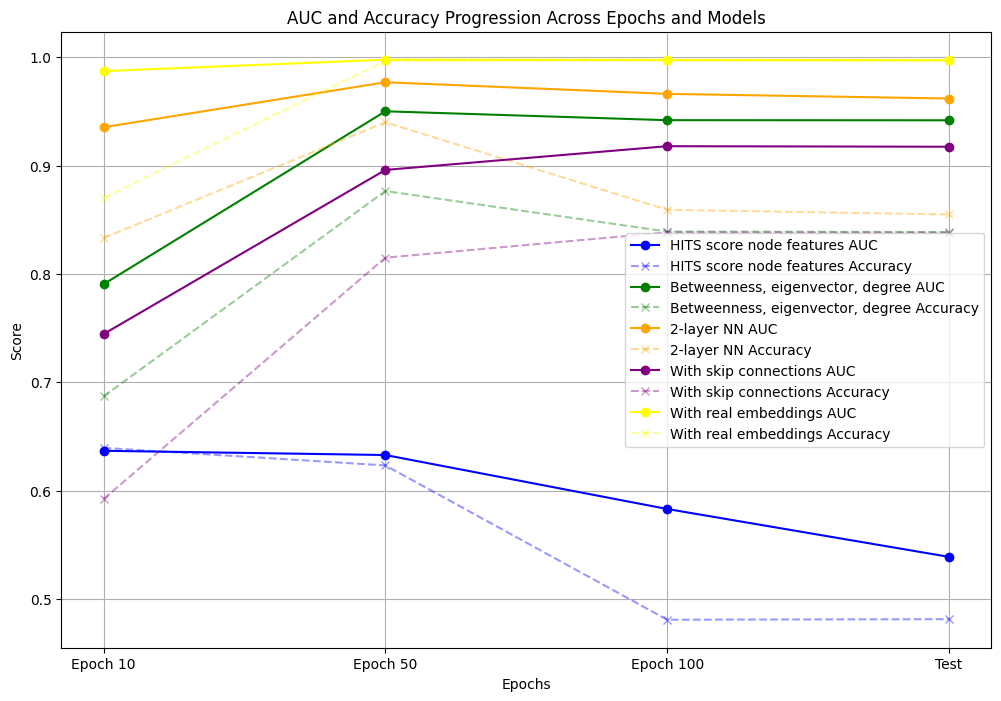

<Figure size 640x480 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt

# Define color schemes for AUC and Accuracy
colors = ['blue', 'green', 'orange', 'purple', 'yellow']

# Data for plotting
epochs = ["Epoch 10", "Epoch 50", "Epoch 100", "Test"]
methods = ["HITS score node features", "Betweenness, eigenvector, degree", "2-layer NN", "With skip connections", "With real embeddings"]

# AUC and Accuracy values
auc_values = [
    [0.6368, 0.6329, 0.5831, 0.5389],
    [0.7905, 0.9501, 0.9419, 0.9418],
    [0.9354, 0.9769, 0.9662, 0.9619],
    [0.7445, 0.8960, 0.9179, 0.9174],
    [0.9872, 0.9977, 0.9975, 0.9973]
]

accuracy_values = [
    [0.6395, 0.6233, 0.4809, 0.4814],
    [0.6870, 0.8765, 0.8391, 0.8387],
    [0.8332, 0.9400, 0.8592, 0.8549],
    [0.5923, 0.8150, 0.8384, 0.8381],
    [0.8701, 0.9966, 0.9967, 0.9963]
]

plt.figure(figsize=(12, 8))
for i, method in enumerate(methods):
    # Plot AUC with a solid line and color gradient
    plt.plot(epochs, auc_values[i], label=f"{method} AUC", marker='o', linestyle='-', color=colors[i], alpha=1)
    # Plot Accuracy with a dashed line and color gradient
    plt.plot(epochs, accuracy_values[i], label=f"{method} Accuracy", marker='x', linestyle='--', color=colors[i], alpha=0.4)

plt.title("AUC and Accuracy Progression Across Epochs and Models")
plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

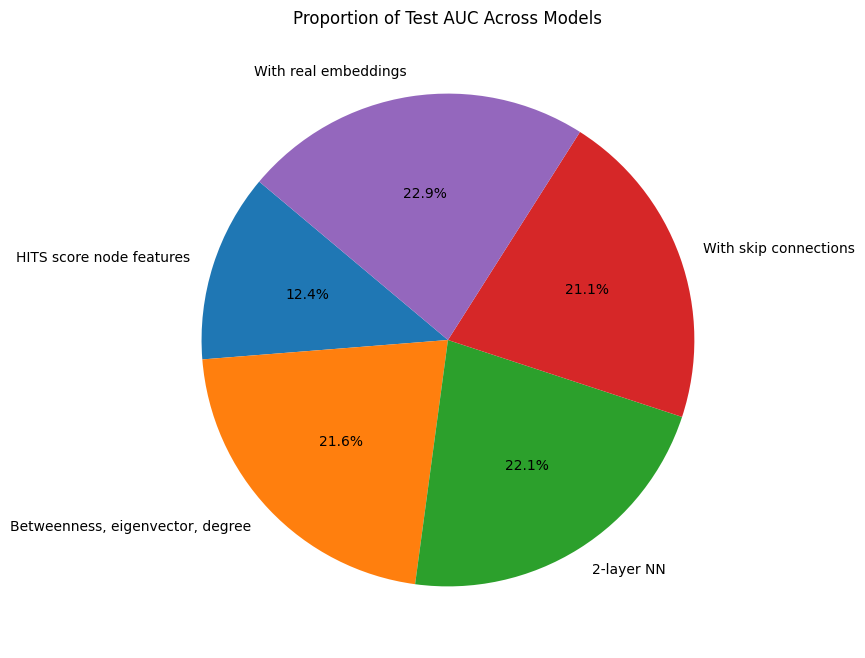

In [3]:
import matplotlib.pyplot as plt

# Data for Test AUC for each model
methods = ["HITS score node features", "Betweenness, eigenvector, degree", "2-layer NN", "With skip connections", "With real embeddings"]
test_auc = [0.5389, 0.9418, 0.9619, 0.9174, 0.9973]

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(test_auc, labels=methods, autopct='%1.1f%%', startangle=140, colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
plt.title("Proportion of Test AUC Across Models")
plt.show()

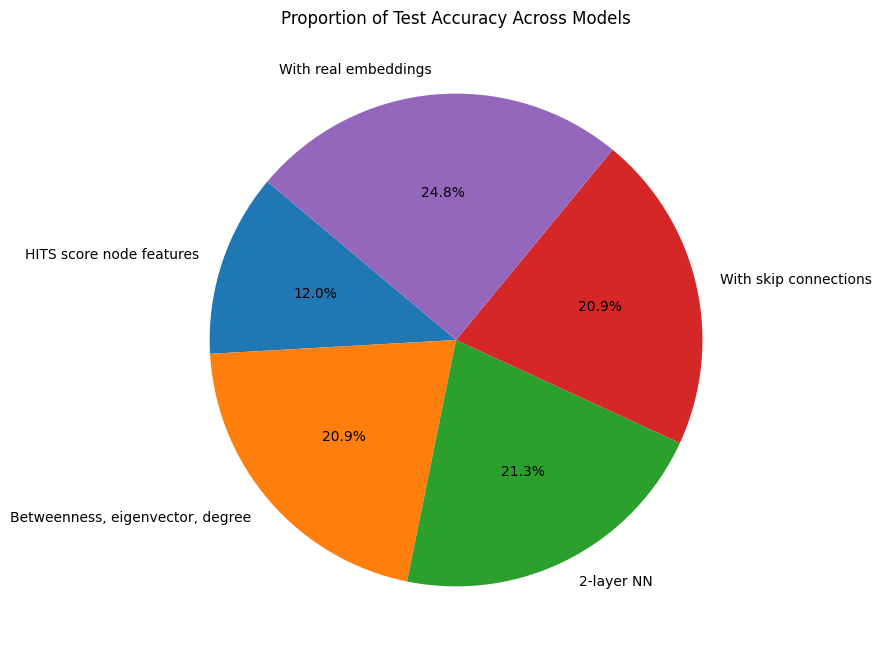

In [4]:
# Data for Test Accuracy for each model
test_accuracy = [0.4814, 0.8387, 0.8549, 0.8381, 0.9963]

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(test_accuracy, labels=methods, autopct='%1.1f%%', startangle=140, colors=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"])
plt.title("Proportion of Test Accuracy Across Models")
plt.show()

In [35]:
print(val_data.edge_label_index_dict)

{('compound', 'interacts', 'target'): tensor([[20641, 28523, 41919,  ..., 30926, 11756, 37793],
        [   84,    13,    75,  ..., 39123, 45677,  3405]], device='cuda:0')}


In [17]:
from torch_geometric.explain import CaptumExplainer, ExplainerConfig, ModelConfig, Explainer
from captum.attr import IntegratedGradients

def get_top_proteins_with_captum_explainer(model, data, protein_idx, drug_idx, device="cuda"):
    # Move model and data to the specified device
    model = model.to(device)
    data = data.to(device)
    
    # Combine heterogeneous node features into a single tensor
    # x_tensor = torch.cat(list(data.x_dict.values()), dim=1).to(device)

    # Combine heterogeneous edge indices into a single tensor
    # edge_index_tensor = torch.cat(list(data.edge_index_dict.values()), dim=1).to(device)

    # Initialize the CaptumExplainer with IntegratedGradients
    # explainer = CaptumExplainer(IntegratedGradients)

    class WrappedModel(torch.nn.Module):
        def __init__(self, model):
            super().__init__()
            self.model = model
            self.predict_link_function = model.predict_link  # Your model's predict function

        def forward(self, x_dict, edge_index_dict):        
            z_dict = self.model(x_dict, edge_index_dict)
            pos_edge_index = data['compound', 'interacts', 'target'].edge_index.to(device)
            return self.predict_link_function(z_dict, pos_edge_index).squeeze()

    # Wrap your model
    wrapped_model = WrappedModel(model)

    model_config = ModelConfig(
        mode='binary_classification',
        task_level='edge',
        return_type='probs',
    )

    explainer = Explainer(
        model=wrapped_model,
        explanation_type='model',
        algorithm=CaptumExplainer(IntegratedGradients),
        node_mask_type='attributes',
        edge_mask_type='object',
        model_config=model_config,
    )

    # Define the explainer configuration
    # explainer_config = ExplainerConfig(
    #     explanation_type="model",  # Explains the model as a whole
    #     node_mask_type="attributes",  # Uses node attributes for attributions
    #     edge_mask_type="object"  # Focuses on explaining edges
    # )

    # Define the model configuration
    # model_config = ModelConfig(
    #     mode="binary_classification",  # Model performs binary classification
    #     task_level="edge",  # Explanations focus on edge-level interactions
    #     return_type="probs"  # Model returns probabilities
    # )

    # Connect the explainer to the model with the configuration
    # explainer.connect(explainer_config, model_config)

    # Define the target as the edge (protein-drug interaction)
    # target = torch.tensor([[protein_idx], [drug_idx]], dtype=torch.long, device=device)

    # Compute attributions
    explanation = explainer(
        x=data.x_dict,  # Node features
        edge_index=data.edge_index_dict,  # Edge indices
    )

    # Extract edge attributions
    edge_mask = explanation.edge_mask

    # Identify edges associated with the given protein and drug
    target_edges = data[('target', 'interacts', 'target')].edge_index
    drug_edges = data[('compound', 'interacts', 'target')].edge_index

    protein_edges = (target_edges[0] == protein_idx).nonzero(as_tuple=True)[0]
    relevant_edges = protein_edges[(drug_edges[0][protein_edges] == drug_idx)]

    # Rank the proteins connected to the given protein by edge attribution importance
    important_edges = edge_mask[relevant_edges].argsort(descending=True)[:5]
    top_proteins = target_edges[1][important_edges]

    return top_proteins


In [18]:
# Select a specific interaction to explain using CHEMBL IDs
drug_chembl_id = 'CHEMBL4112929'  # Example CHEMBL ID for drug
protein_chembl_id = 'CHEMBL4523987'  # Example CHEMBL ID for protein

# Get the node indices for the drug and protein
drug_idx = compound_map[drug_chembl_id]
protein_idx = target_map[protein_chembl_id]

top_proteins = get_top_proteins_with_captum_explainer(model, data, protein_idx, drug_idx)
print("Top 5 proteins interacting with the protein-drug pair:", top_proteins)

AttributeError: 'target' is already present as a node type